# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
import umap
import shap

/opt/anaconda3/envs/phd-formants/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/processed/formant_features.csv")

In [3]:
df.head()

,vowel_id,perceptive_label,vowel_duration,euclid_dist,f1_delta,f2_delta,f1_linear_slope,f2_linear_slope,f1_quadratic_coef,f2_quadratic_coef,...,f1_max_second_deriv,f1_std_second_deriv,f2_mean_first_deriv,f2_min_first_deriv,f2_max_first_deriv,f2_std_first_deriv,f2_mean_second_deriv,f2_min_second_deriv,f2_max_second_deriv,f2_std_second_deriv
0,001-001-001,monophthong,0.144963,1.869833,-1.996197,-1.290173,-18.714447,-18.338053,-475.587774,-186.808788,...,3894.853995,2149.362804,-16.415144,-25.894188,9.202128,10.413943,-373.617576,-1026.063608,278.828457,380.475816
1,001-001-002,monophthong,0.119054,0.433654,0.201263,-0.505578,7.667227,-4.377506,-444.157522,-53.611665,...,1376.561588,1320.769444,-5.369952,-14.046368,-2.369783,3.156565,-107.223331,-522.971069,308.524408,242.444512
2,001-001-003,monophthong,0.143313,2.366344,-1.998246,-0.462354,-25.049961,-8.997313,-189.913887,-5.401283,...,223.992882,352.119785,-5.571802,-14.177390,11.583270,7.698735,-10.802565,-1201.367039,1179.761909,694.281162
3,001-001-004,monophthong,0.101878,1.900395,-1.585384,-1.434164,-17.215741,-21.216989,-110.566944,14.439932,...,3314.763276,2061.968792,-27.738895,-60.863503,-11.104984,14.880653,28.879864,-3286.574167,3344.333895,1933.416733
4,001-001-005,monophthong,0.171726,1.398421,-1.729350,-0.436878,-11.746823,-6.679641,-164.638939,-47.723732,...,-269.568007,34.819986,-5.417164,-9.196709,5.523048,3.981876,-95.447465,-462.728577,271.833648,214.181057


In [4]:
df["perceptive_label"].value_counts()

perceptive_label
monophthong    849
diphthong      155
Name: count, dtype: int64

# feature correlation

<Axes: >

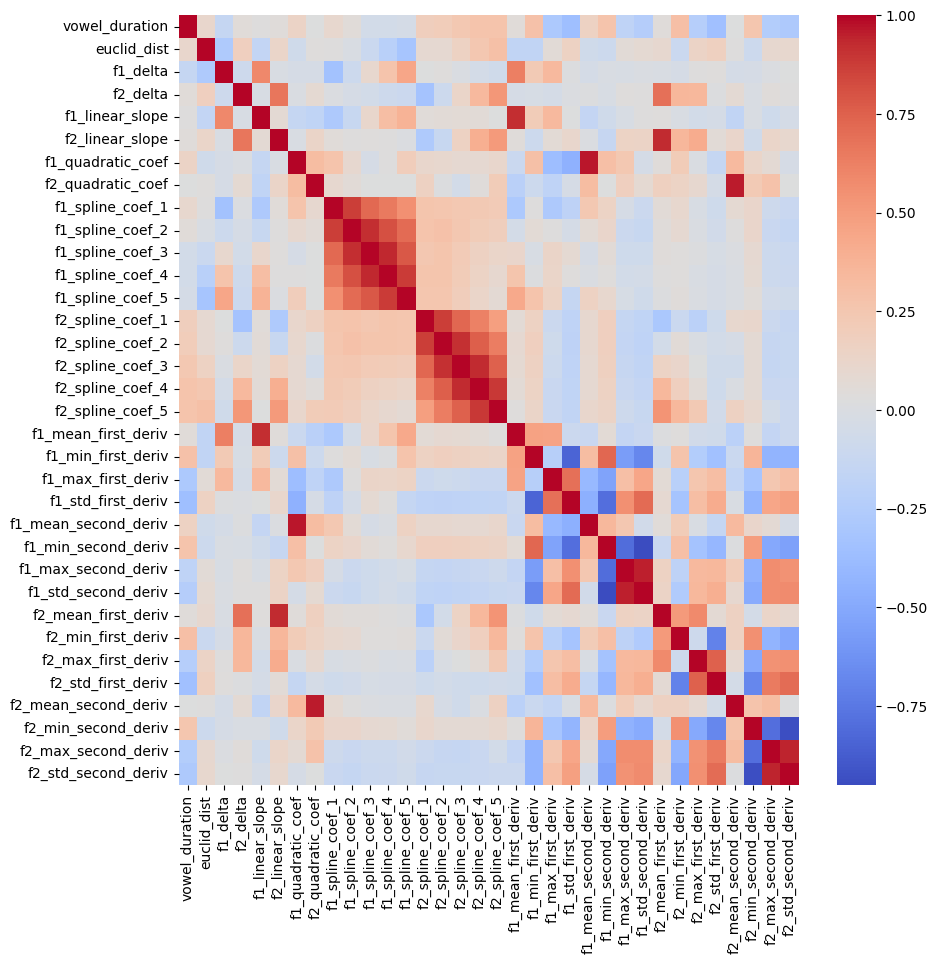

In [5]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    df.drop(columns=["vowel_id", "perceptive_label"]).corr(),
    cmap="coolwarm",
    annot=False,
)

# UMAP projection

/opt/anaconda3/envs/phd-formants/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/phd-formants/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


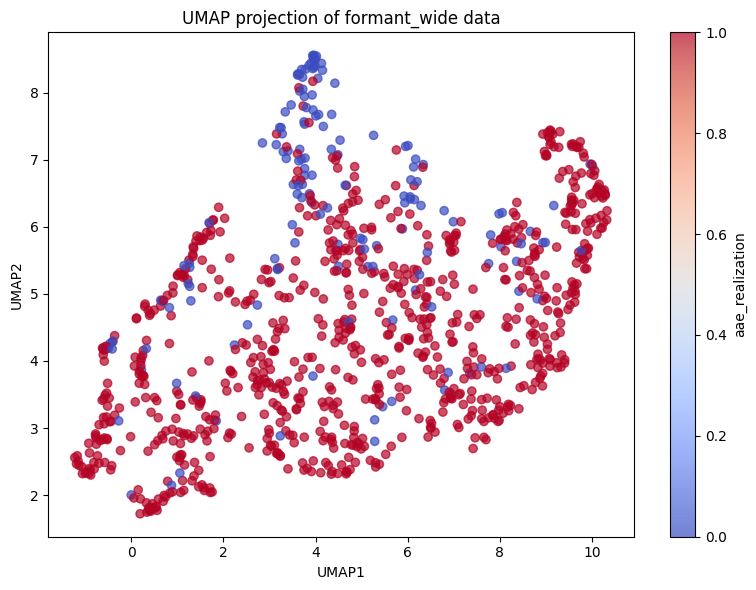

In [6]:
# use umap to reduce dimensionality of formant_wide data and plot
wide_form = pd.read_csv("../data/interim/formant_wide.csv")

# select only f1/f2 columns for UMAP
f1_cols = [col for col in wide_form.columns if col.startswith("f1_")]
f2_cols = [col for col in wide_form.columns if col.startswith("f2_")]
formant_cols = f1_cols + f2_cols

X_wide = wide_form[formant_cols].values

# fit UMAP
umap_model = umap.UMAP(random_state=42)
X_umap_wide = umap_model.fit_transform(X_wide)

# add to dataframe for plotting
wide_form["UMAP1"] = X_umap_wide[:, 0]
wide_form["UMAP2"] = X_umap_wide[:, 1]

# plot, colored by aae_realization if present
if "aae_realization" in wide_form.columns:
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        wide_form["UMAP1"],
        wide_form["UMAP2"],
        c=wide_form["aae_realization"],
        cmap="coolwarm",
        alpha=0.7,
    )
    plt.colorbar(scatter, label="aae_realization")
    plt.title("UMAP projection of formant_wide data")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(8, 6))
    plt.scatter(wide_form["UMAP1"], wide_form["UMAP2"], alpha=0.7)
    plt.title("UMAP projection of formant_wide data")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.tight_layout()
    plt.show()


# feature EDA

In [7]:
# get features
features = df.columns.tolist()

# drop first two columns
features = features[2:]

In [8]:
# select f1 features
f1_features = [f for f in features if f.startswith("f1")]

# select f2 features
f2_features = [f for f in features if f.startswith("f2")]

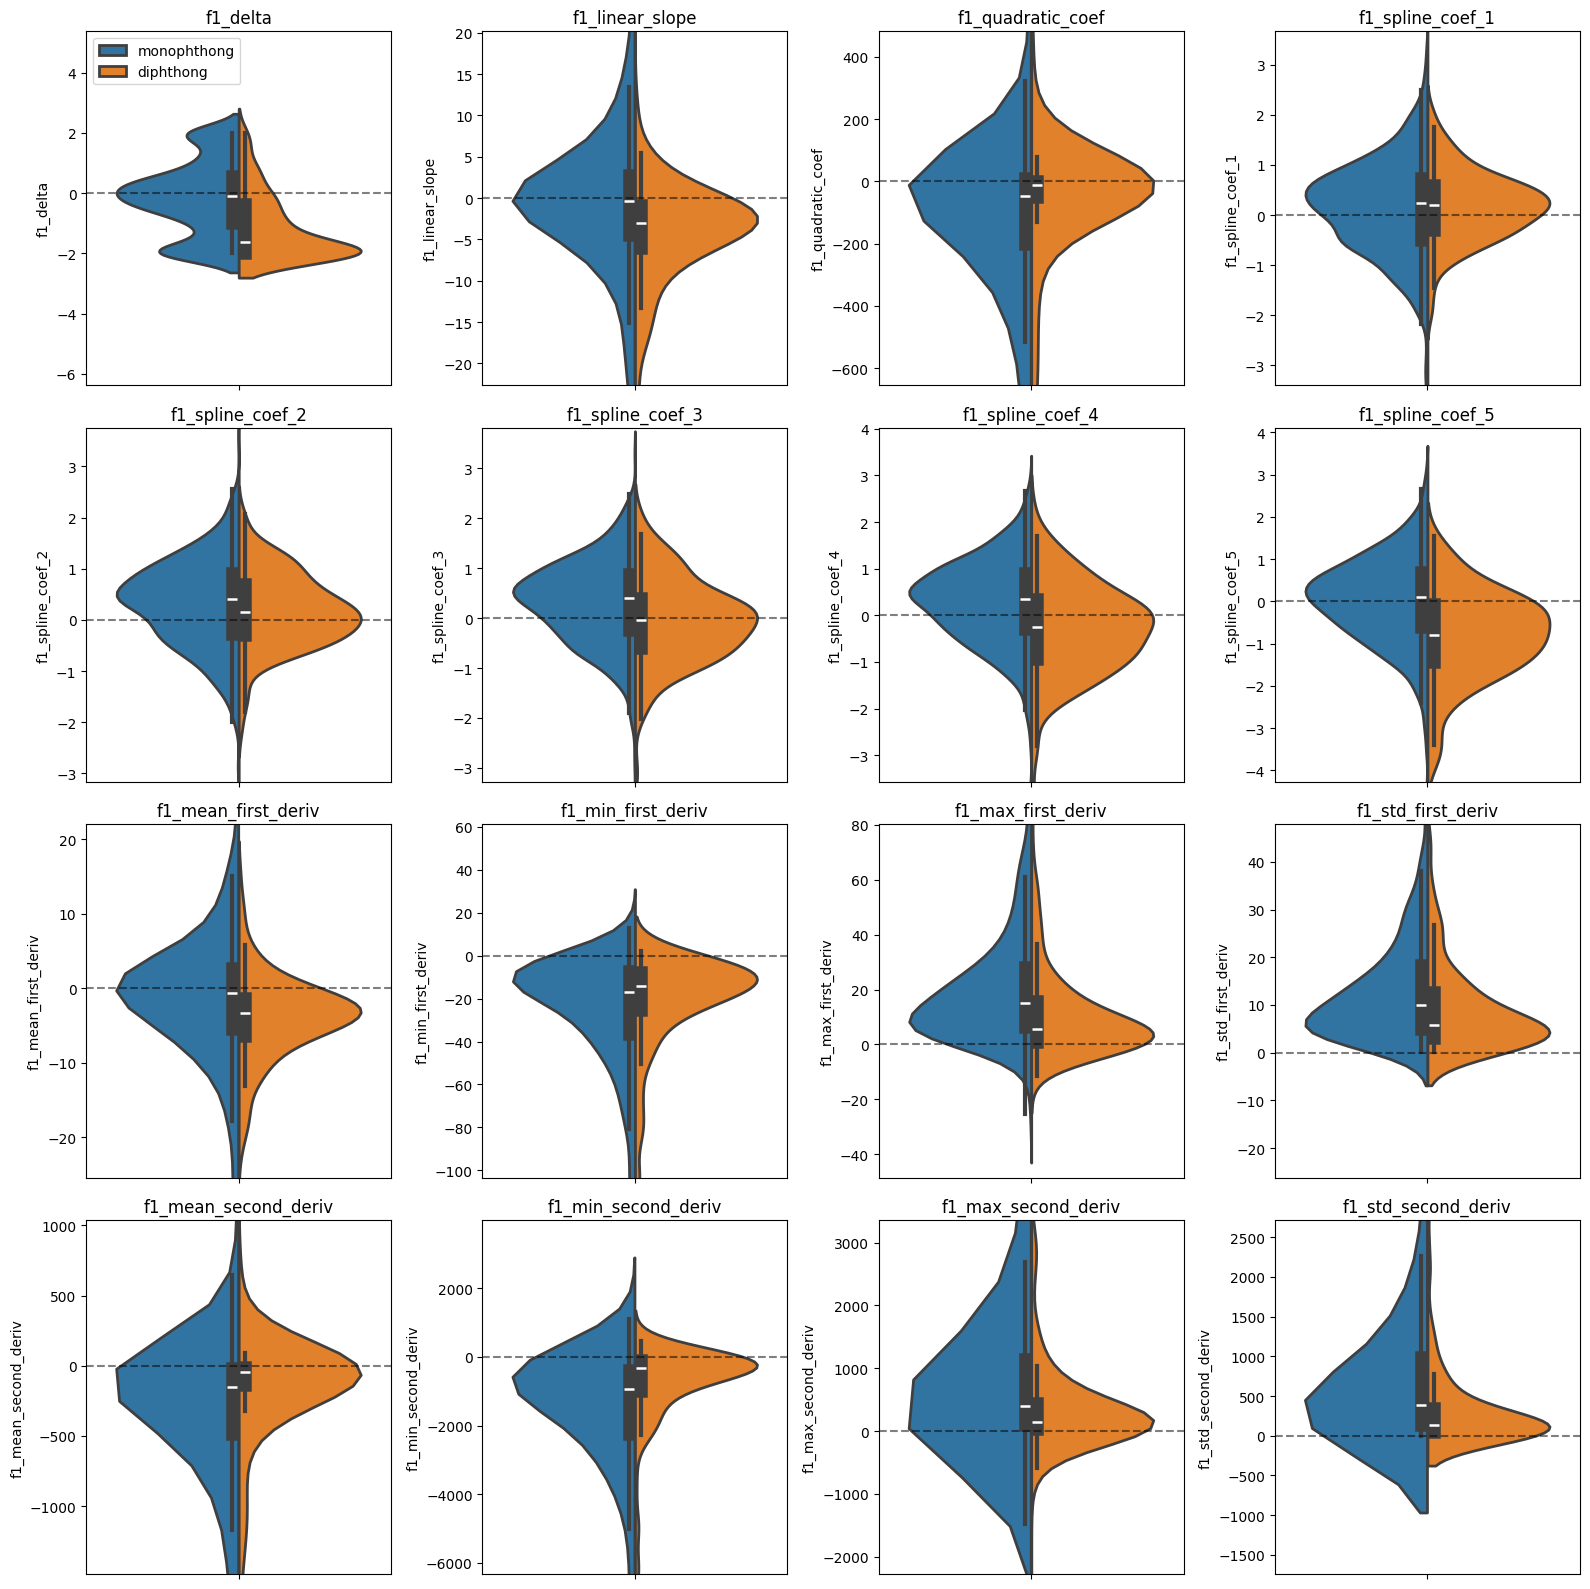

In [9]:
# calculate grid dimensions
n_features = len(f1_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

# create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

# plot each feature
for i, feat in enumerate(f1_features):
    # only show legend for first plot
    show_legend = i == 0
    sns.violinplot(
        hue="perceptive_label",
        y=feat,
        data=df,
        split=True,
        inner="box",
        linewidth=2,
        ax=axes[i],
        legend=show_legend,
    )
    axes[i].set_title(f"{feat}")

    # add horizontal line at y=0
    axes[i].axhline(y=0, color="black", linestyle="--", alpha=0.5)

    # set ylim to 5 times iqr
    q1 = df[feat].quantile(0.25)
    q3 = df[feat].quantile(0.75)
    iqr = q3 - q1
    y_min = q1 - 2.5 * iqr
    y_max = q3 + 2.5 * iqr
    axes[i].set_ylim(y_min, y_max)

    # move legend to top left for first plot
    if i == 0:
        axes[i].legend(loc="upper left")

# hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

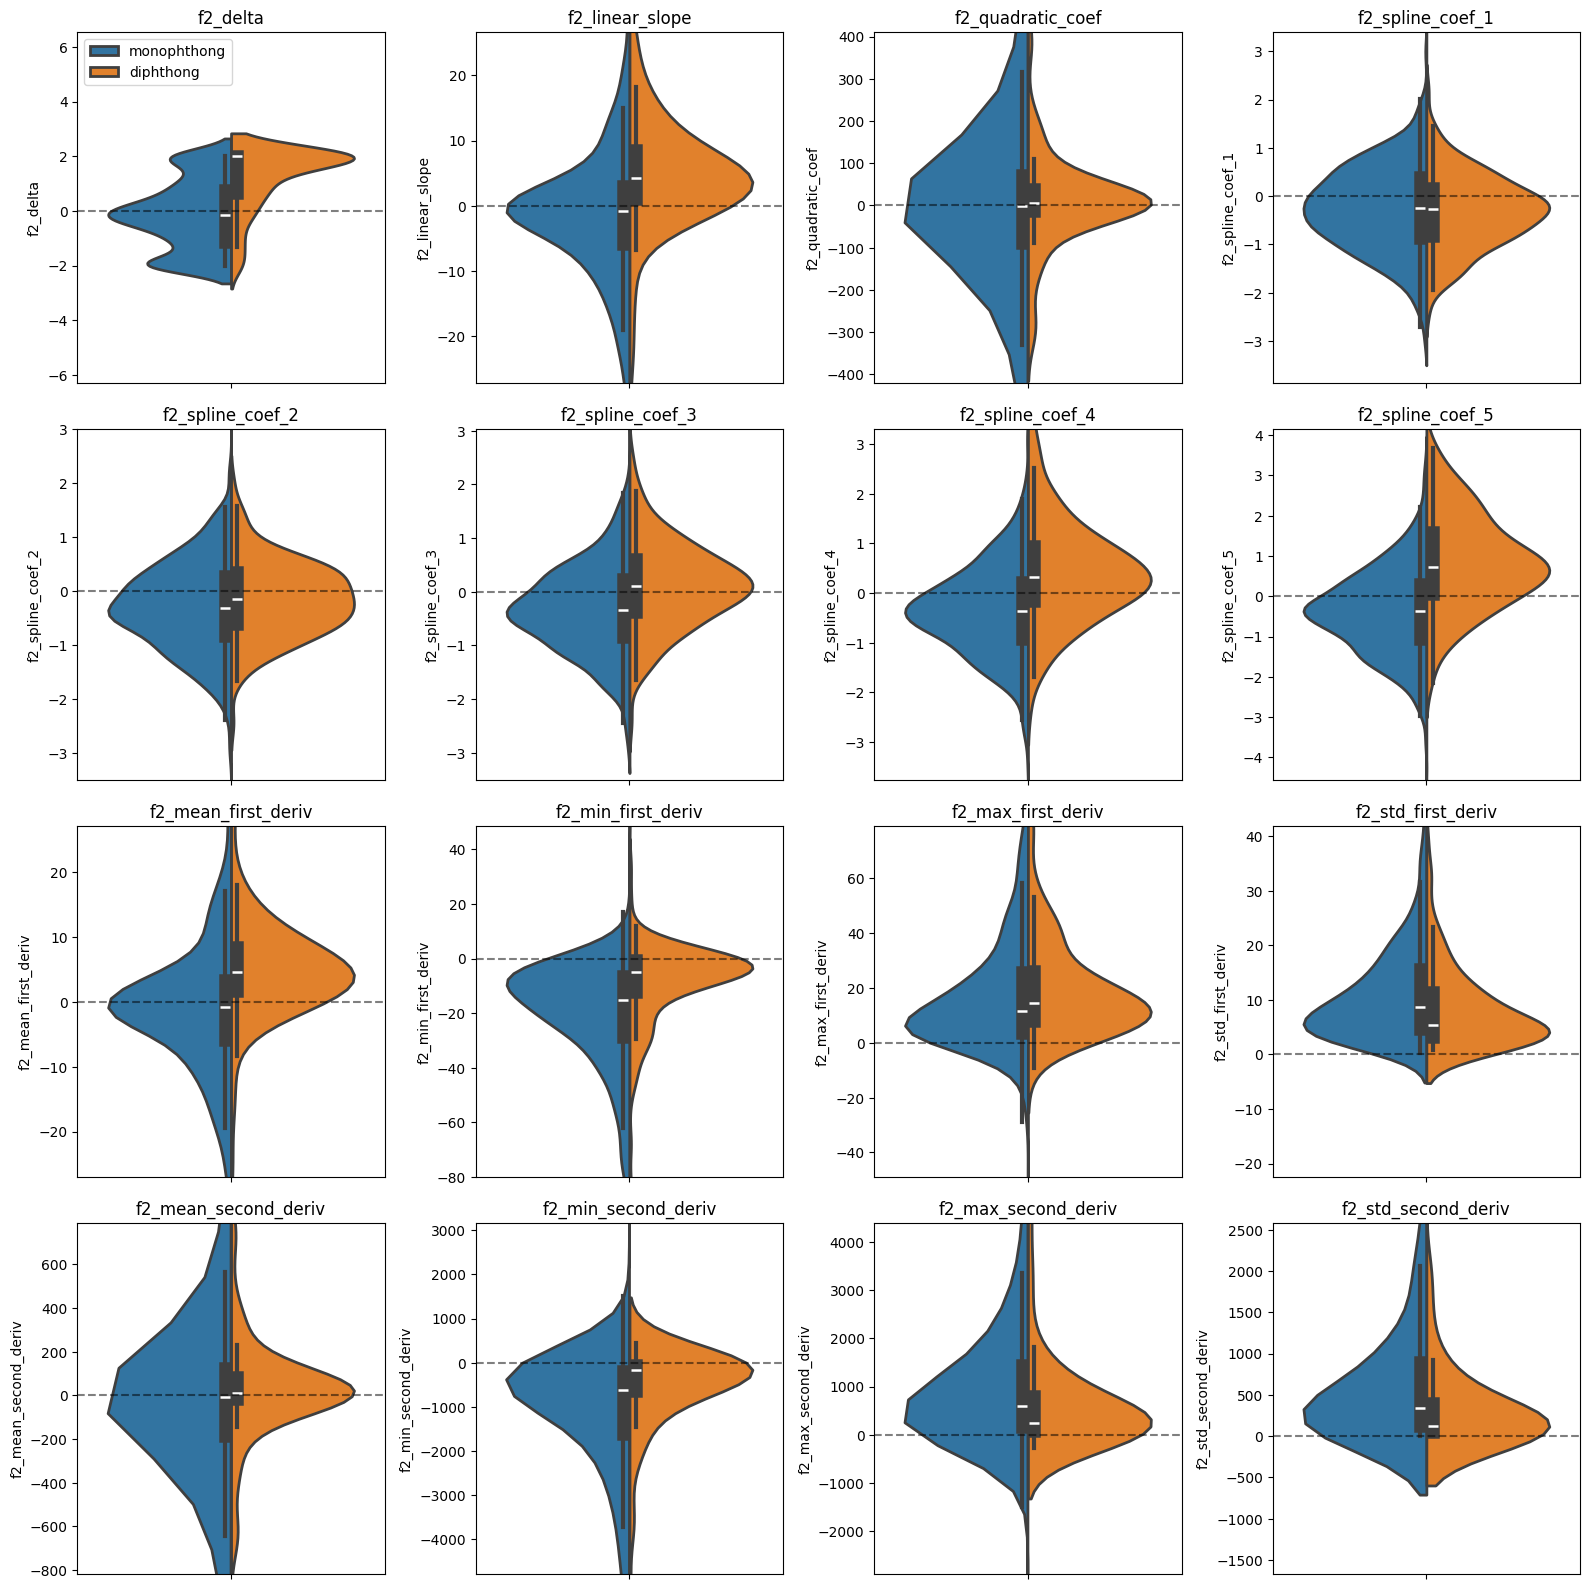

In [10]:
# calculate grid dimensions
n_features = len(f2_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

# create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

# plot each feature
for i, feat in enumerate(f2_features):
    # only show legend for first plot
    show_legend = i == 0
    sns.violinplot(
        hue="perceptive_label",
        y=feat,
        data=df,
        split=True,
        inner="box",
        linewidth=2,
        ax=axes[i],
        legend=show_legend,
    )
    axes[i].set_title(f"{feat}")

    # add horizontal line at y=0
    axes[i].axhline(y=0, color="black", linestyle="--", alpha=0.5)

    # set ylim to 5 times iqr
    q1 = df[feat].quantile(0.25)
    q3 = df[feat].quantile(0.75)
    iqr = q3 - q1
    y_min = q1 - 2.5 * iqr
    y_max = q3 + 2.5 * iqr
    axes[i].set_ylim(y_min, y_max)

    # move legend to top left for first plot
    if i == 0:
        axes[i].legend(loc="upper left")

# hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# model

In [11]:
# map perceptive label to 0 and 1
df["perceptive_label"] = df["perceptive_label"].map({"monophthong": 1, "diphthong": 0})

In [12]:
# select features
vowel_ids = df["vowel_id"]  # keep for reference later

X = df.drop(columns=["perceptive_label", "vowel_id"])
y = df["perceptive_label"]

In [ ]:
# train test split
X_train, X_test, y_train, y_test, train_vowel_ids, test_vowel_ids = train_test_split(
    X, y, vowel_ids, test_size=0.25, random_state=42, stratify=y
)

In [14]:
# fit model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [15]:
# check model predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.9083665338645418
Precision: 0.9162995594713657
Recall: 0.9811320754716981
F1 Score: 0.9476082004555809
ROC AUC Score: 0.7469762941461053


In [16]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.51      0.63        39
           1       0.92      0.98      0.95       212

    accuracy                           0.91       251
   macro avg       0.87      0.75      0.79       251
weighted avg       0.90      0.91      0.90       251



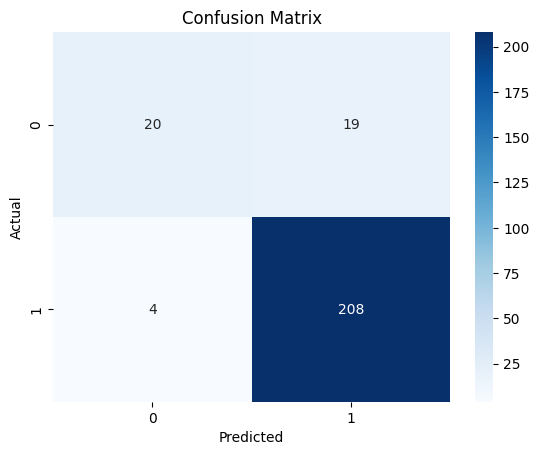

In [17]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# shap values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

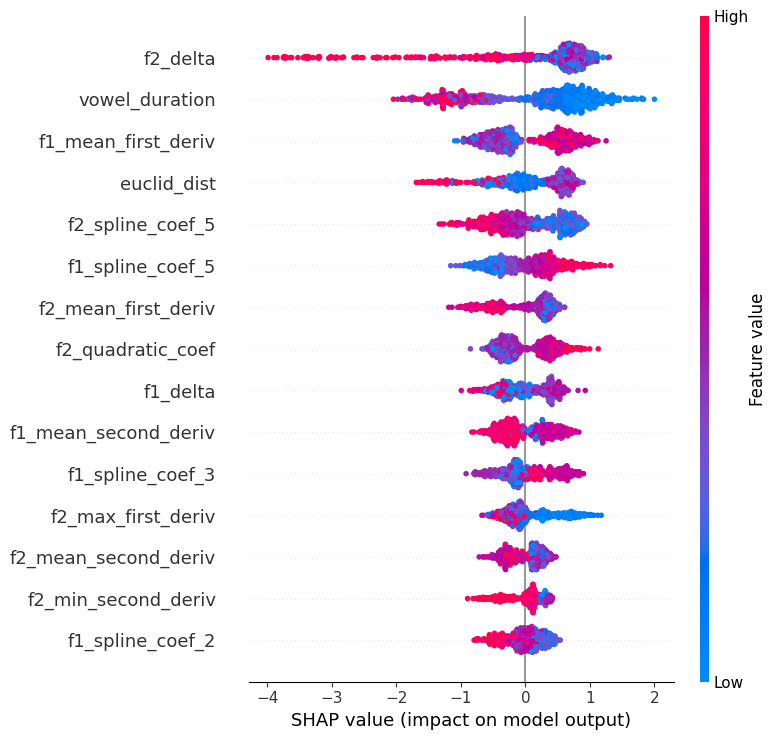

In [19]:
# shap summary plot
shap.summary_plot(shap_values, X_train, max_display=15)

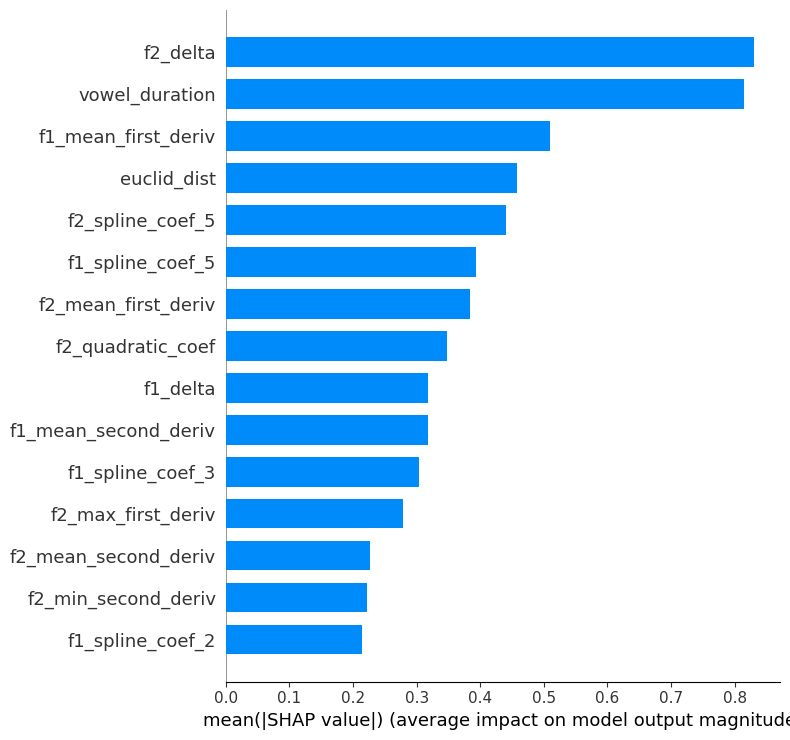

In [20]:
# shap bar plot asbolute importance
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=15)

vowel id for datapoint 2: 001-001-020


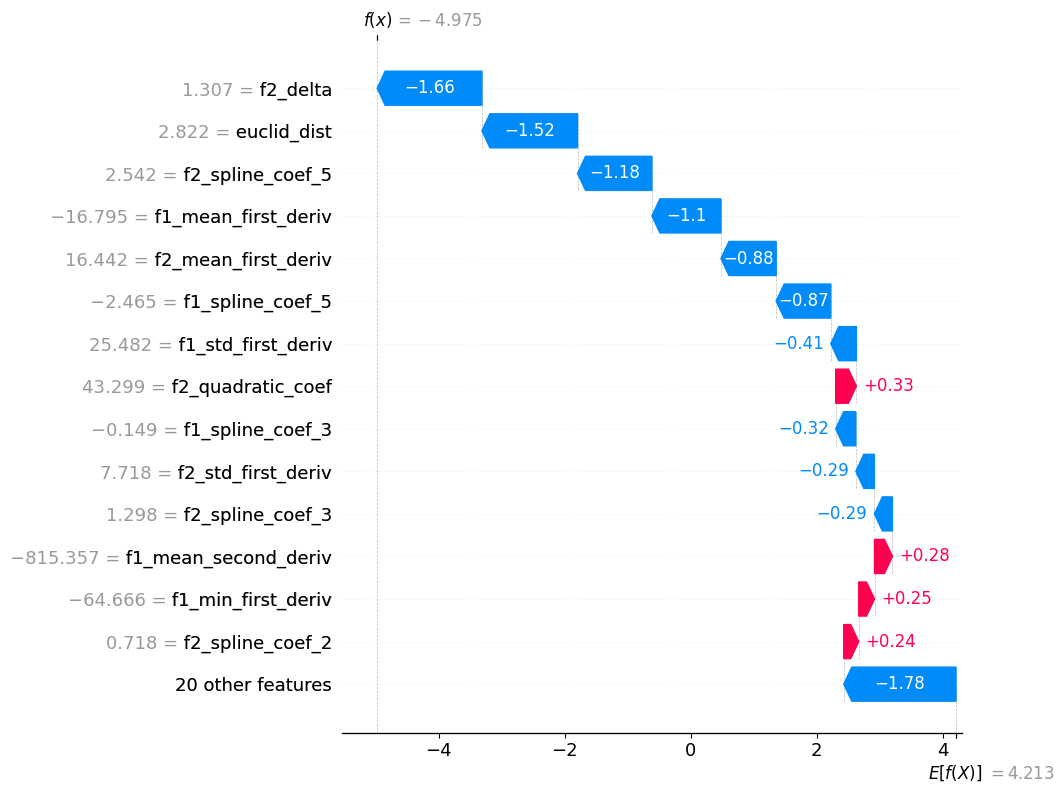

In [21]:
# shap waterfall plot
print("vowel id for datapoint 2:", train_vowel_ids.iloc[1])
shap.plots.waterfall(shap_values[1], max_display=15)

In [22]:
# get indices in X_train for given list of vowel_ids
vowels_of_interest = ["005-003-012", "006-001-005"]

idxs_of_interest_in_X_train = []
train_vowel_ids_reset = train_vowel_ids.reset_index(drop=True)

for vowel_id in vowels_of_interest:
    idxs = train_vowel_ids_reset[train_vowel_ids_reset == vowel_id].index.tolist()
    if idxs:
        idxs_of_interest_in_X_train.extend(idxs)
        for idx in idxs:
            print(f"index in X_train for vowel_id {vowel_id}: {idx}")
            print("verifying vowel id at that index:", train_vowel_ids_reset.iloc[idx])
            print()
    else:
        print(f"vowel_id {vowel_id} not found in train_vowel_ids")

index in X_train for vowel_id 005-003-012: 686
verifying vowel id at that index: 005-003-012

index in X_train for vowel_id 006-001-005: 522
verifying vowel id at that index: 006-001-005



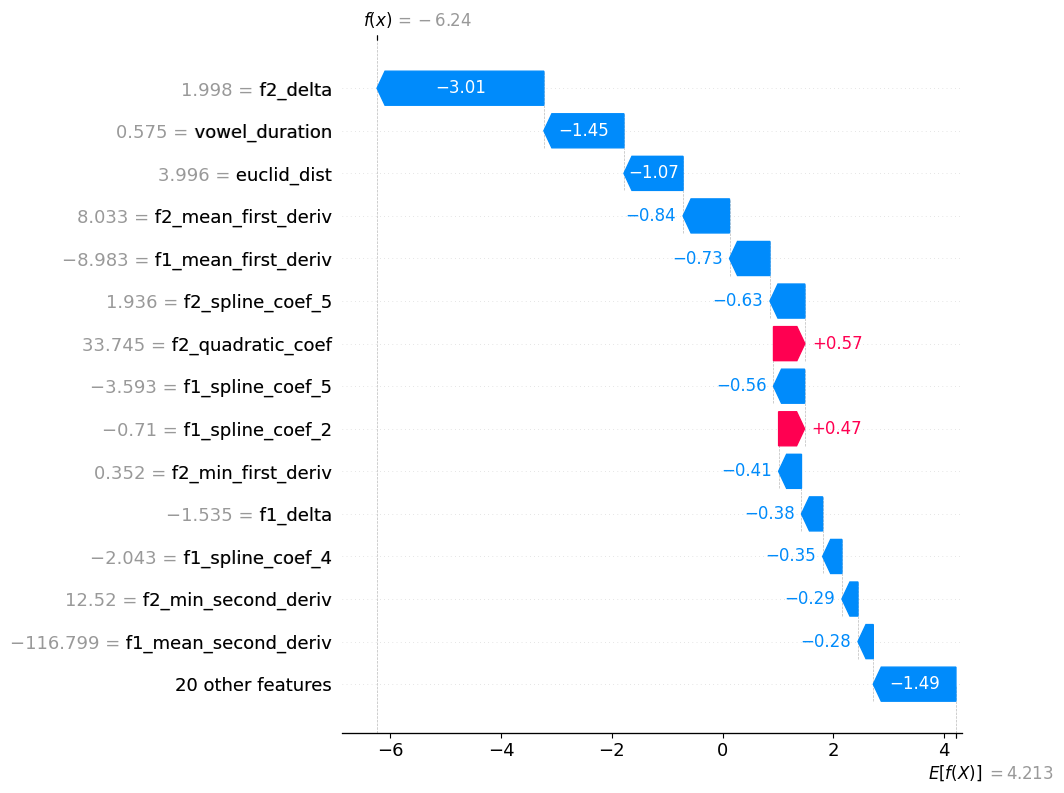

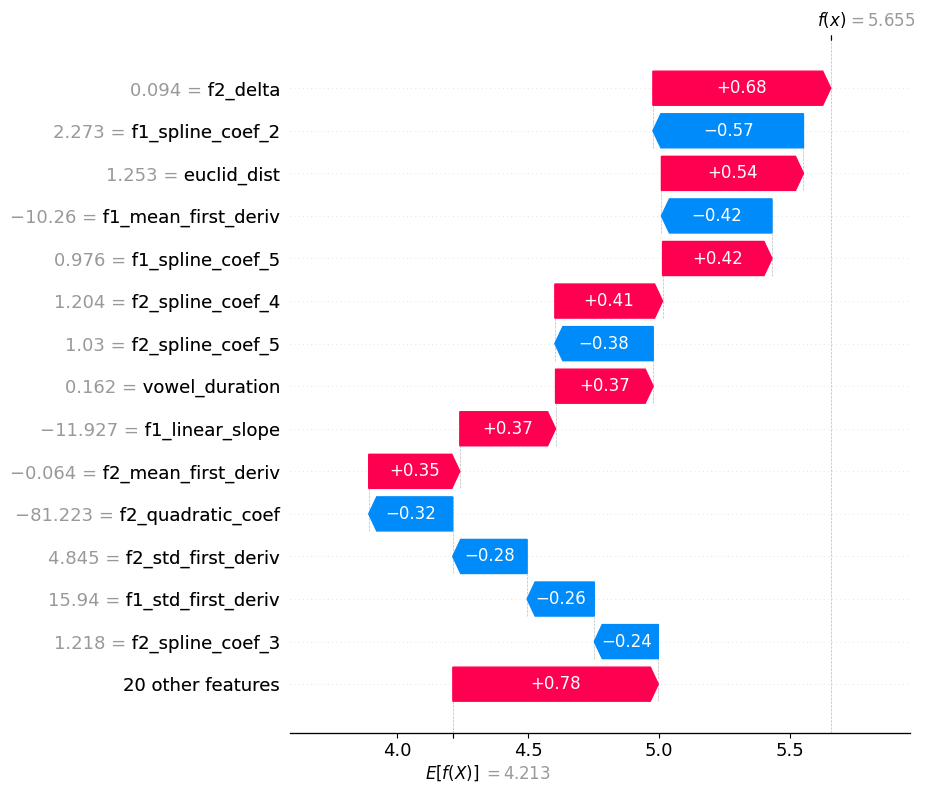

In [23]:
# shap waterfall plots
for vowel in idxs_of_interest_in_X_train:
    shap.plots.waterfall(shap_values[vowel], max_display=15)